# Automatic differentiation

Some synonyms: autodiff, autograd, computational differentiation, algorithmic differentiation, reverse mode differentiation.

It is distinct from classical methods of differentiation (numerical differentiation and symbolic differentiation) and it handles better functions with many inputs and higher-order derivatives.

It works by applying the chain rule (typically the partial derivative) to a sequence (forward pass) of arithmetic operations.

## Automatic differentiation in Python

### Automatic differentiation with PyTorch

Let's calculate $\frac{dy}{dx}$ at $x = 5$ where $y = x^2$:

$$\frac{dy}{dx} = \frac{d}{dx}(x^2) = 2x = 2(5) = 10$$

In [1]:
import torch

In [2]:
x = torch.tensor(5.0)
x

tensor(5.)

When calculating a derivative, we want to keep track of the gradient; it is not necessary in normal circumstances, and it would consume memory.

In [3]:
x.requires_grad_()

tensor(5., requires_grad=True)

In [4]:
y = x**2
y.backward()

In [5]:
x.grad

tensor(10.)

### Automatic differentiation with TensorFlow

In [6]:
import tensorflow as tf

In [7]:
x = tf.Variable(5.0)

In [8]:
with tf.GradientTape() as t:
    t.watch(x)
    y = x**2

In [9]:
t.gradient(y, x)

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

## The line equation as a tensor graph

Let's use a simple line equation $y = mx + b$, where $m$ is the slope and $b$ is the y-intercept.

Represented as a directed acyclic graph (DAG):



In [30]:
import matplotlib.pyplot as plt
import networkx as nx

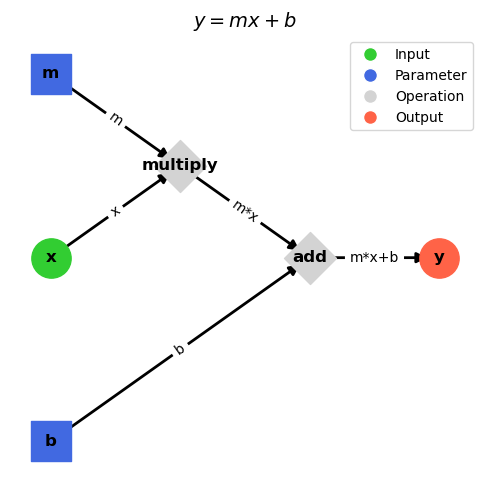

In [31]:
def create_computational_graph(figsize=(5, 5)):
    # Create a directed graph
    G = nx.DiGraph()

    # Define node categories
    inputs = ['x']
    parameters = ['m', 'b']
    operations = ['multiply', 'add']
    outputs = ['y']

    # Add nodes with their types
    for node in inputs:
        G.add_node(node, type='input')
    for node in parameters:
        G.add_node(node, type='parameter')
    for node in operations:
        G.add_node(node, type='operation')
    for node in outputs:
        G.add_node(node, type='output')

    # Add edges with labels to represent operations
    edges = [
        ('x', 'multiply', {'label': 'x'}),
        ('m', 'multiply', {'label': 'm'}),
        ('multiply', 'add', {'label': 'm*x'}),
        ('b', 'add', {'label': 'b'}),
        ('add', 'y', {'label': 'm*x+b'})
    ]
    G.add_edges_from(edges)

    # Define positions for visualization
    pos = {
        'x': (0, 1),
        'm': (0, 2),
        'b': (0, 0),
        'multiply': (1, 1.5),
        'add': (2, 1),
        'y': (3, 1)
    }

    # Create figure
    plt.figure(figsize=figsize)

    # Node styling by type
    node_styles = {
        'input': {'color': 'limegreen', 'shape': 'o', 'size': 800},
        'parameter': {'color': 'royalblue', 'shape': 's', 'size': 800},
        'operation': {'color': 'lightgray', 'shape': 'D', 'size': 700},
        'output': {'color': 'tomato', 'shape': 'o', 'size': 800}
    }

    # Draw nodes by type for better styling control
    for node_type, style in node_styles.items():
        nodelist = [n for n, d in G.nodes(data=True) if d.get('type') == node_type]
        nx.draw_networkx_nodes(G, pos,
                              nodelist=nodelist,
                              node_color=style['color'],
                              node_shape=style['shape'],
                              node_size=style['size'])

    # Draw edges and labels
    nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=15, width=2)
    nx.draw_networkx_labels(G, pos, font_weight='bold', font_size=12)

    # Add edge labels
    edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Create legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                 markerfacecolor=style['color'], markersize=10,
                                 label=f"{node_type.capitalize()}")
                      for node_type, style in node_styles.items()]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.title(r"$y = mx + b$", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    return plt.gca()

# Create and display the graph
create_computational_graph()
plt.show()

In [97]:
x = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7.])
x

tensor([0., 1., 2., 3., 4., 5., 6., 7.])

The values were created using the equation of a line $y = mx + b$. This way, we know what the model parameters to be learned are, say, $m = -0.5$ and $b = 2$.

Random, normally-distributed noise has been added to simulate sampling error:

In [50]:
# y = -0.5*x + 2 + torch.normal(mean=torch.zeros(8), std=0.2)
# y

tensor([ 2.0459,  1.5685,  1.1809,  0.7573,  0.1594, -0.5702, -0.7137, -1.3890])

For this example, I'll re-use the values from the Linear Algebra notebook [3.7 - Moore-Penrose Pseudoinverse](https://github.com/valatwork/linear-algebra/blob/main/project/015-moore-penrose-pseudoinverse.ipynb)

In [98]:
y = torch.tensor([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37])
y

tensor([ 1.8600,  1.3100,  0.6200,  0.3300,  0.0900, -0.6700, -1.2300, -1.3700])

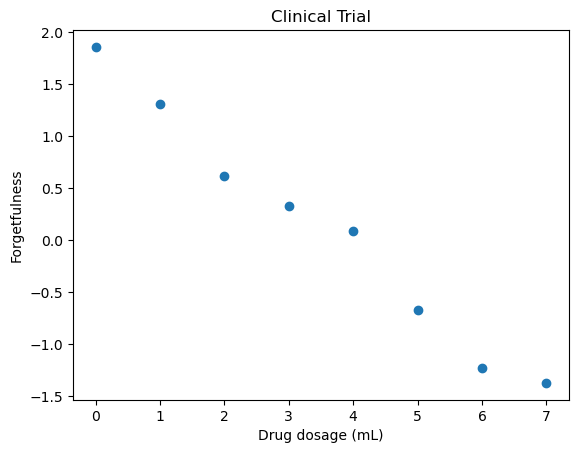

In [99]:
fig, ax = plt.subplots()
plt.title("Clinical Trial")
plt.xlabel("Drug dosage (mL)")
plt.ylabel("Forgetfulness")
_ = ax.scatter(x, y)

Let's initialize the model parameters $m$ and $b$ with random values close to $0$:

In [100]:
m = torch.tensor([0.9]).requires_grad_()
m

tensor([0.9000], requires_grad=True)

In [101]:
b = torch.tensor([0.1]).requires_grad_()
b

tensor([0.1000], requires_grad=True)

In [102]:
def regression(my_x, my_m, my_b):
    return my_m*my_x + my_b

In [103]:
def regression_plot(my_x, my_y, my_m, my_b):

    fig, ax = plt.subplots()

    ax.scatter(my_x, my_y)

    x_min, x_max = ax.get_xlim()
    y_min = regression(x_min, my_m, my_b).detach().item()
    y_max = regression(x_max, my_m, my_b).detach().item()

    ax.set_xlim([x_min, x_max])
    _ = ax.plot([x_min, x_max], [y_min, y_max])

In this example, the data doesn't fit very well:

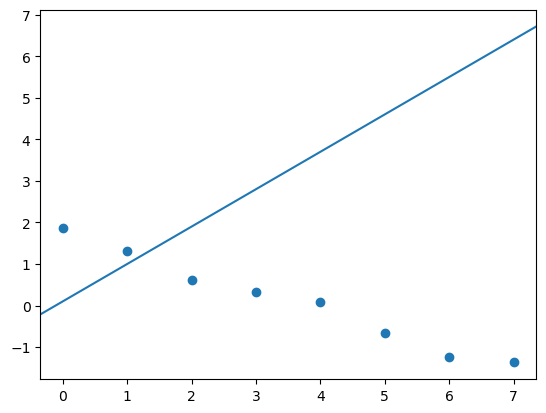

In [104]:
regression_plot(x, y, m, b)

Now let's calculate $\hat{y}$, which is the predicted value of $y$ given the model parameters $m$ and $b$.

The equation for $\hat{y}$ is $\hat{y} = f(x, m, b)$

In [105]:
yhat = regression(x, m, b)
yhat

tensor([0.1000, 1.0000, 1.9000, 2.8000, 3.7000, 4.6000, 5.5000, 6.4000],
       grad_fn=<AddBackward0>)

And now let's calculate the loss function $C$ as $C = g(\hat{y}, y)$, where $g$ is the cost function. In this example, the cost function is the mean squared error (MSE):

In [106]:
def mse(my_yhat, my_y):
    sigma = torch.sum((my_yhat - my_y)**2)
    return sigma/len(my_y)

In [107]:
C = mse(yhat, y)
C

tensor(19.6755, grad_fn=<DivBackward0>)

Now let's use automatic differentiation to calculate the gradient of $C$ w.r.t. $m$ and $b$:

In [108]:
C.backward()

In [109]:
m.grad

tensor([36.3050])

In [110]:
b.grad

tensor([6.2650])

And now let's use gradient descent to update the model parameters $m$ and $b$:

In [111]:
optimizer = torch.optim.SGD([m, b], lr=0.01)

In [112]:
optimizer.step()

In [113]:
m

tensor([0.5369], requires_grad=True)

In [114]:
b

tensor([0.0374], requires_grad=True)

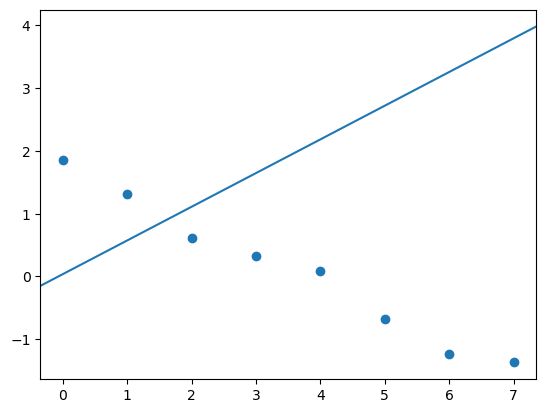

In [115]:
regression_plot(x, y, m, b)

$C = g(f(x, m, b), y)$

In [116]:
C = mse(regression(x, m, b), y)
C

tensor(8.5722, grad_fn=<DivBackward0>)

In [93]:
epochs = 1000
for epoch in range(epochs):

    optimizer.zero_grad() # Reset gradients to zero; else they accumulate

    yhat = regression(x, m, b) # Step 1
    C = mse(yhat, y) # Step 2

    C.backward() # Step 3
    optimizer.step() # Step 4

    print('Epoch {}, cost {}, m grad {}, b grad {}'.format(epoch, '%.3g' % C.item(), '%.3g' % m.grad.item(), '%.3g' % b.grad.item()))

Epoch 0, cost 8.57, m grad 23.2, b grad 3.6
Epoch 1, cost 4.08, m grad 14.8, b grad 1.91
Epoch 2, cost 2.25, m grad 9.49, b grad 0.831
Epoch 3, cost 1.51, m grad 6.11, b grad 0.15
Epoch 4, cost 1.2, m grad 3.96, b grad -0.28
Epoch 5, cost 1.07, m grad 2.59, b grad -0.552
Epoch 6, cost 1.01, m grad 1.72, b grad -0.723
Epoch 7, cost 0.981, m grad 1.17, b grad -0.829
Epoch 8, cost 0.962, m grad 0.82, b grad -0.894
Epoch 9, cost 0.948, m grad 0.595, b grad -0.934
Epoch 10, cost 0.936, m grad 0.452, b grad -0.957
Epoch 11, cost 0.925, m grad 0.361, b grad -0.969
Epoch 12, cost 0.915, m grad 0.302, b grad -0.975
Epoch 13, cost 0.904, m grad 0.265, b grad -0.977
Epoch 14, cost 0.894, m grad 0.241, b grad -0.976
Epoch 15, cost 0.884, m grad 0.225, b grad -0.973
Epoch 16, cost 0.874, m grad 0.214, b grad -0.969
Epoch 17, cost 0.864, m grad 0.207, b grad -0.965
Epoch 18, cost 0.854, m grad 0.202, b grad -0.96
Epoch 19, cost 0.845, m grad 0.199, b grad -0.955
Epoch 20, cost 0.835, m grad 0.196, b

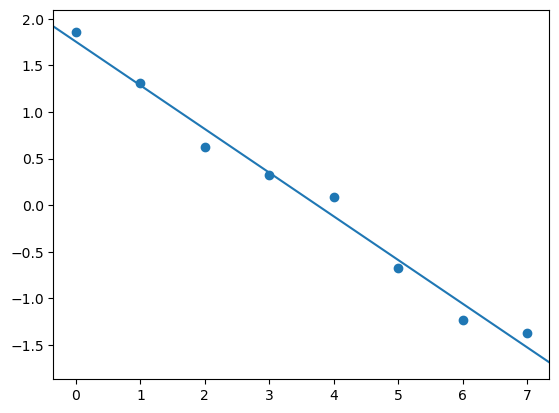

In [94]:
regression_plot(x, y, m, b)

In [95]:
m.item()

-0.4681258499622345

In [96]:
b.item()

1.7542961835861206